# Import Libraries

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib


In [252]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from scipy.stats import loguniform

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from torchinfo import summary
from torchmetrics.regression import MeanAbsoluteError
from  pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

import os
import json
import sklearn

In [253]:
# Had to "pip install openpyxl"
!pip install openpyxl
dataset = pd.read_excel("pr11_credit_scores.xlsx")


# EDA

In [254]:
dataset.info()

# The fact that we have some variables as objects, when they should be strings or numbers, points us to the fact that there are sveral data types mixed together (which should not happen) and alter us to data cleaningdataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       99909 non-null   object 
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             99909 non-null   object 
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               99909 non-null   object 
 13  Type_of_Loan              88509 non-null   ob

In [255]:
dataset.describe(include="all")

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,99909.0,99909,99909,99909,84920.000000,99909.000000,99909.000000,99909.000000,99909.0,88509,100000.000000,92998.0,100000,98035.000000,100000,100000,100000.000000,90970,100000,100000.000000,95521,100000,98800,100000
unique,100000,12500,44,10139,1799.0,12501,31,18936,NaN,NaN,NaN,NaN,434.0,6260,NaN,762.0,4384,NaN,4,13178,NaN,404,3,NaN,91049,13,98792,3
top,0x1602,CUS_0xd40,August,Langep,38.0,#F%$D@*&8,_______,17273.83,NaN,NaN,NaN,NaN,3.0,Not Specified,NaN,19.0,_,NaN,Standard,1360.45,NaN,15 Years and 11 Months,Yes,NaN,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12384,44,2831.0,5565,7055,16,NaN,NaN,NaN,NaN,14368.0,1406,NaN,5327.0,2091,NaN,36479,24,NaN,446,52326,NaN,4305,25487,9,53174
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4194.071131,17.104395,22.495621,72.469027,NaN,NaN,21.068780,NaN,NaN,27.754251,NaN,NaN,32.285173,NaN,NaN,1403.118217,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3183.605038,117.454091,129.115463,466.383442,NaN,NaN,14.860104,NaN,NaN,193.177339,NaN,NaN,5.116875,NaN,NaN,8306.041270,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.645417,-1.000000,0.000000,1.000000,NaN,NaN,-5.000000,NaN,NaN,0.000000,NaN,NaN,20.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1625.597917,3.000000,4.000000,8.000000,NaN,NaN,10.000000,NaN,NaN,3.000000,NaN,NaN,28.052567,NaN,NaN,30.306660,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.745000,6.000000,5.000000,13.000000,NaN,NaN,18.000000,NaN,NaN,6.000000,NaN,NaN,32.305784,NaN,NaN,69.249473,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5957.448333,7.000000,7.000000,20.000000,NaN,NaN,28.000000,NaN,NaN,9.000000,NaN,NaN,36.496663,NaN,NaN,161.224249,NaN,NaN,NaN,NaN


In [256]:
pd.set_option('display.max_columns', None)
dataset.head(24)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4,9.27,4.0,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8_,11.27,4.0,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good
7,0x1609,CUS_0xd40,August,NaN,23,#F%$D@*&8,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,6,11.27,4.0,Good,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28_,004-07-5839,_______,34847.84,3037.986667,2.0,4.0,6.0,1,Credit-Builder Loan,3,4,5.42,2.0,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825168246,Low_spent_Small_value_payments,470.69062692529184,Standard
9,0x160f,CUS_0x21b1,February,Rick Rothackerj,28,004-07-5839,Teacher,34847.84,3037.986667,2.0,4.0,6.0,1,Credit-Builder Loan,7,1,7.42,2.0,Good,605.03,38.550848,26 Years and 8 Months,No,18.816215,40.39123782853101,High_spent_Large_value_payments,484.5912142650067,Good


In [257]:
# By looking at the variables in the dataset and which type of variables they should be, we know that faulty values present in columns that do not match their data type cause the data type of the column to be off. The objective of this cell is to identify which type of columns we should have and set them straight.

categorical_variables = ["ID", "Customer_ID", "Month", "Name", "SSN", "Occupation", "Type_of_Loan", "Credit_Mix", "Credit_History_Age", "Payment_of_Min_Amount", "Payment_Behaviour", "Credit_Score"]
numerical_variables = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt", "Credit_Utilization_Ratio", "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"]


for column in dataset.columns:
    if column in categorical_variables and dataset[column].dtype not in ["object", "category"]:
        dataset[column] = dataset[column].astype("str").astype("category")
    elif column in numerical_variables and dataset[column].dtype not in ["float64", "int64"]:
        dataset[column] = pd.to_numeric(dataset[column], errors="coerce")



In [258]:
# We now see that variables are in the correct data type that correspnds to them 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       94974 non-null   float64
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             92932 non-null   float64
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               95127 non-null   float64
 13  Type_of_Loan              88509 non-null   ob

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


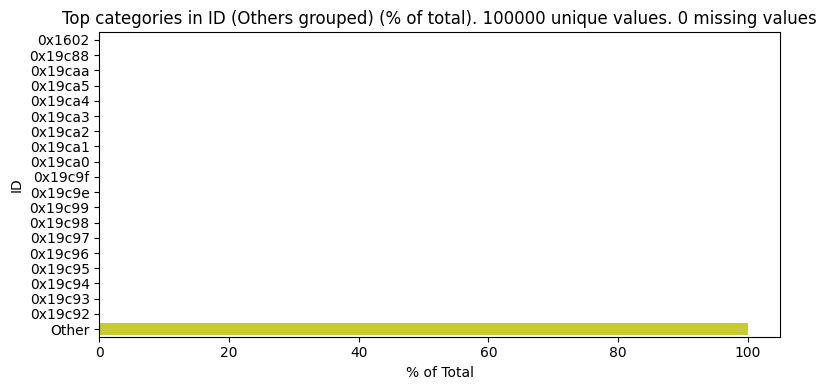

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


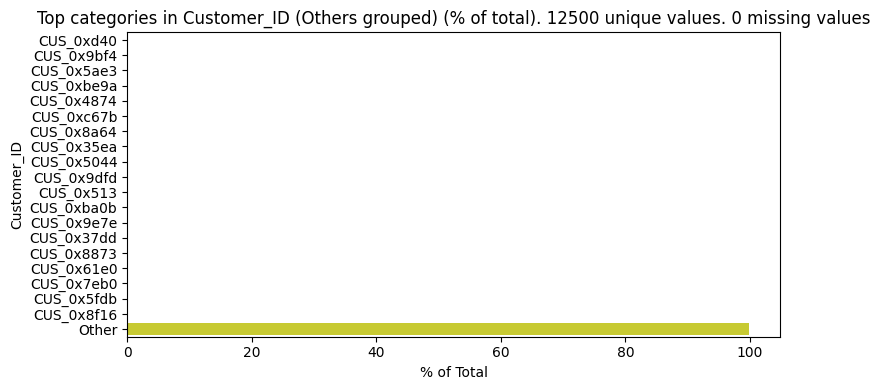

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


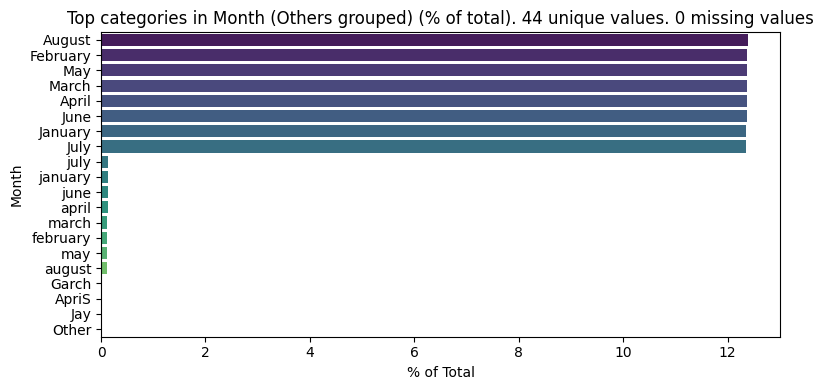

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


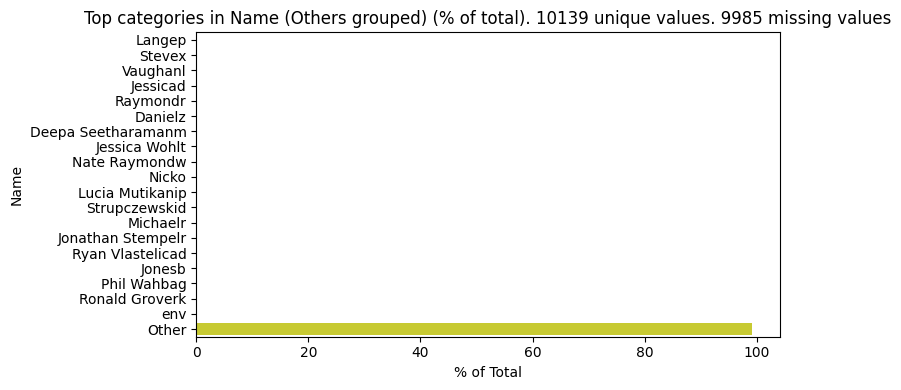

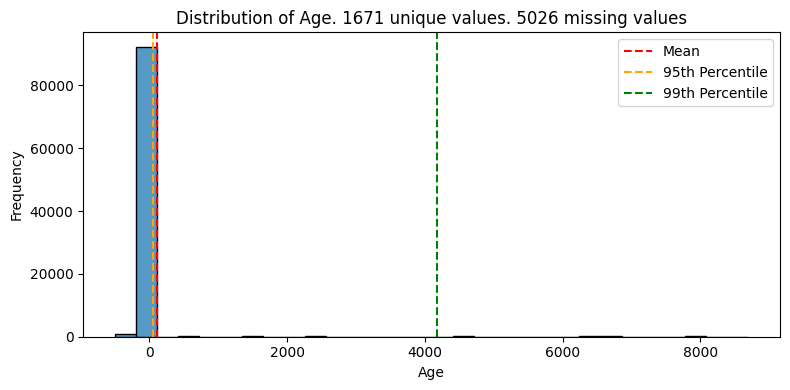

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


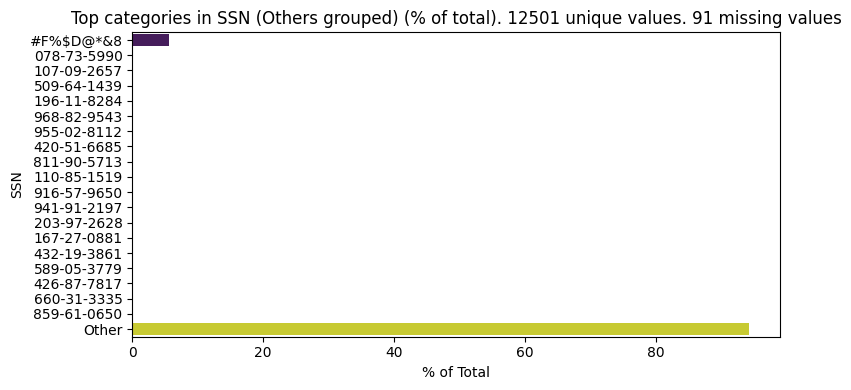

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


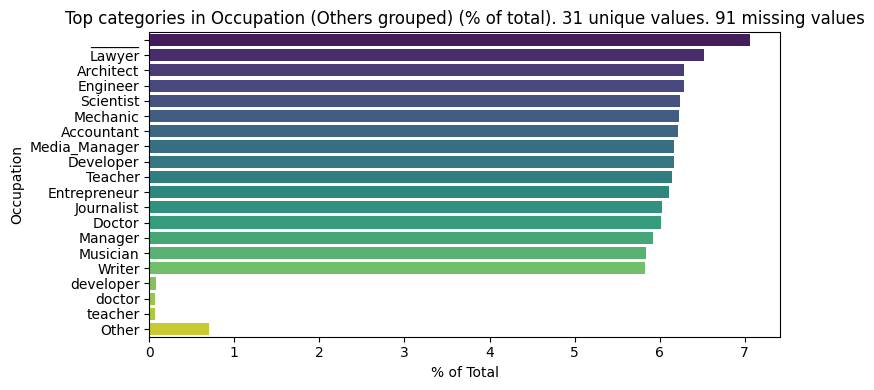

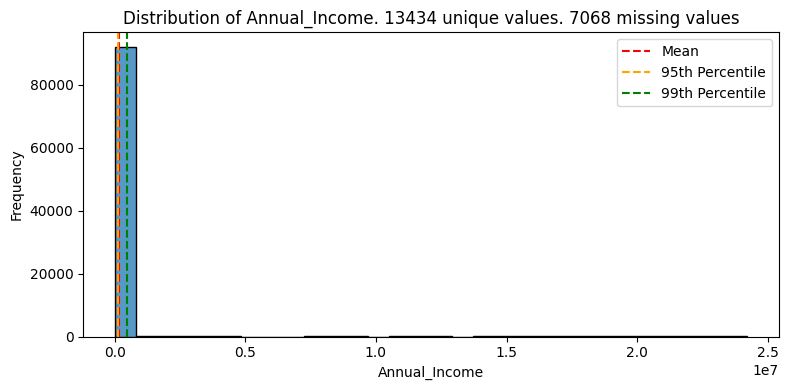

<Figure size 640x480 with 0 Axes>

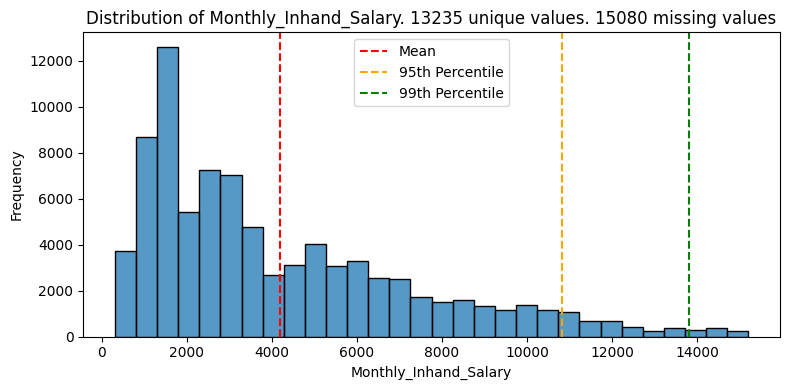

<Figure size 640x480 with 0 Axes>

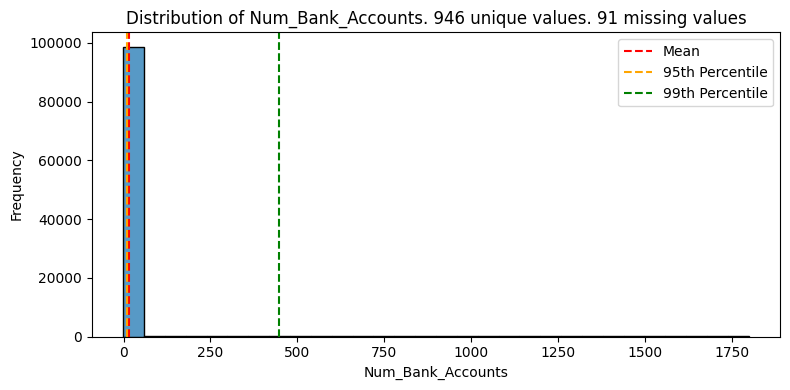

<Figure size 640x480 with 0 Axes>

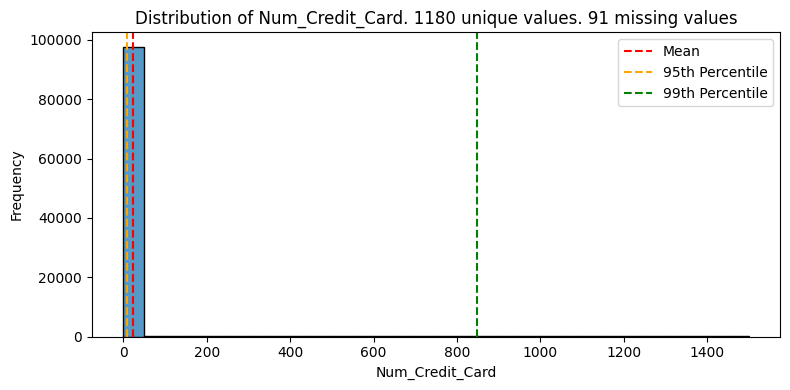

<Figure size 640x480 with 0 Axes>

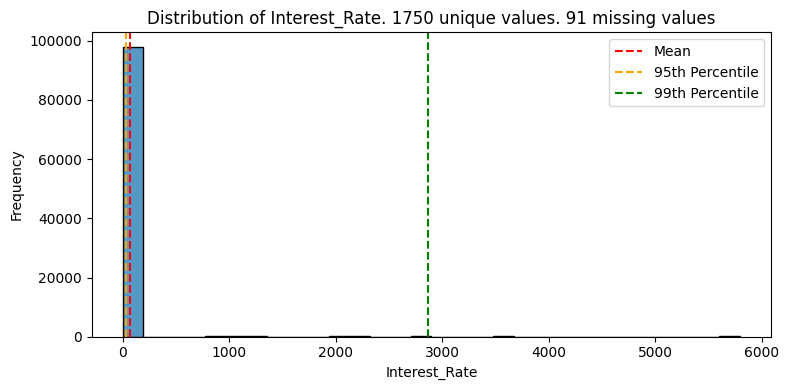

<Figure size 640x480 with 0 Axes>

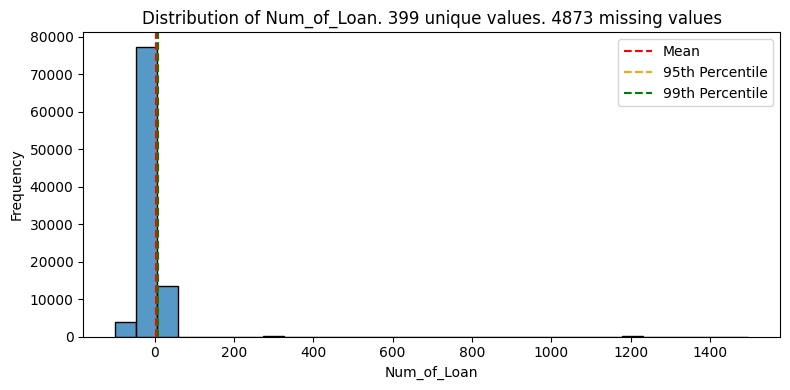

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


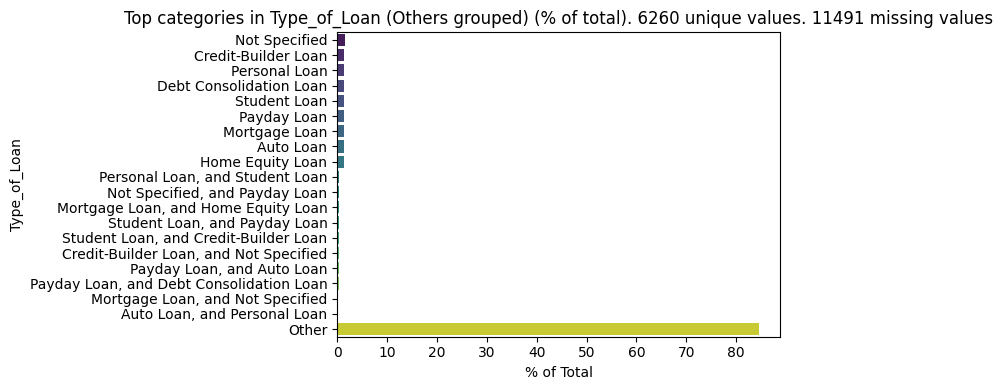

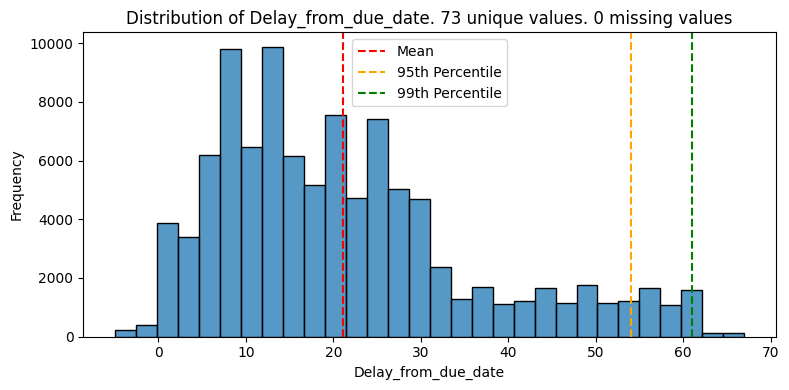

<Figure size 640x480 with 0 Axes>

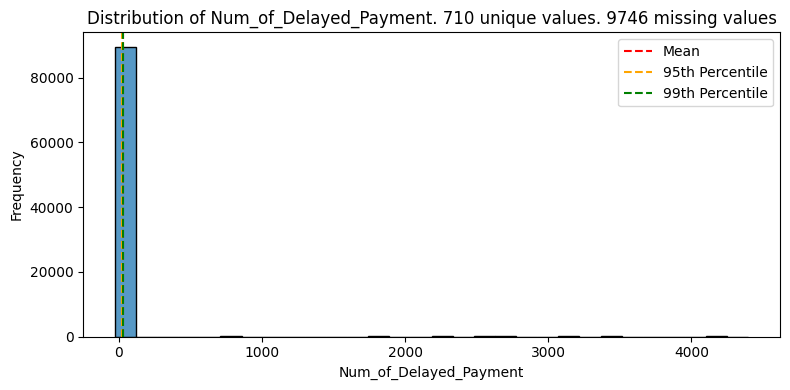

<Figure size 640x480 with 0 Axes>

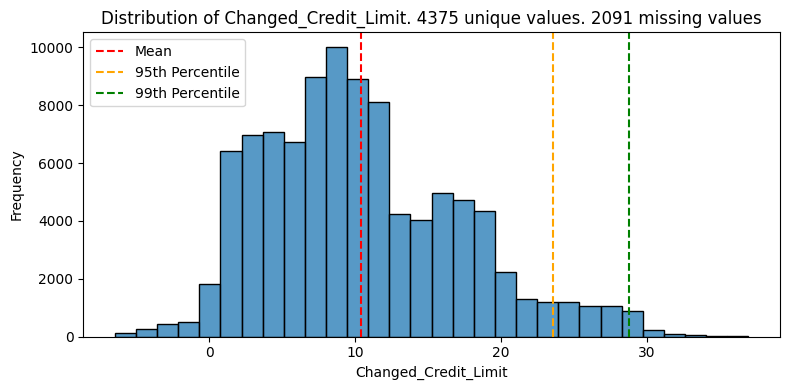

<Figure size 640x480 with 0 Axes>

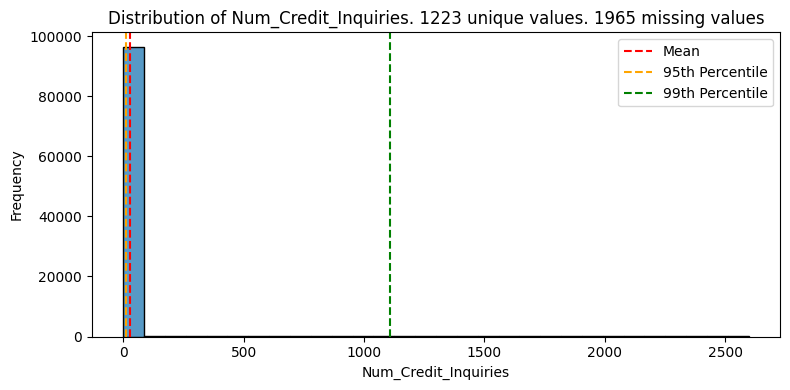

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


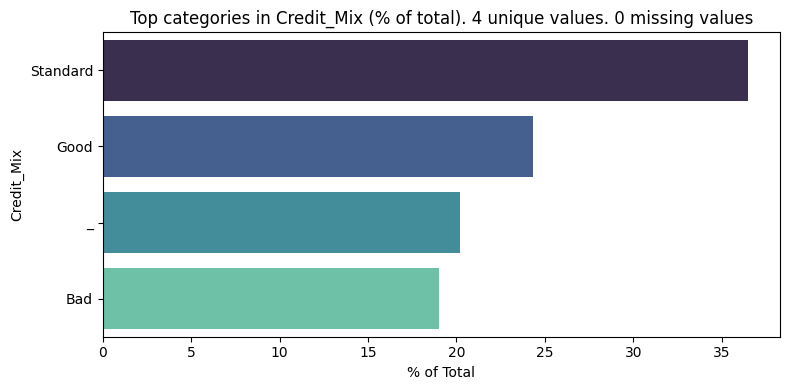

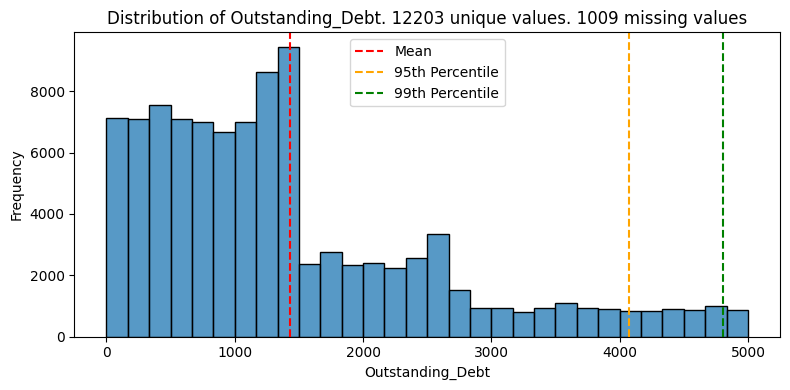

<Figure size 640x480 with 0 Axes>

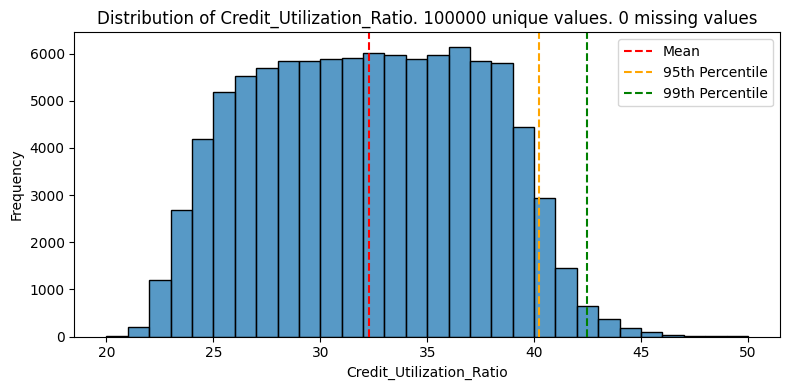

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


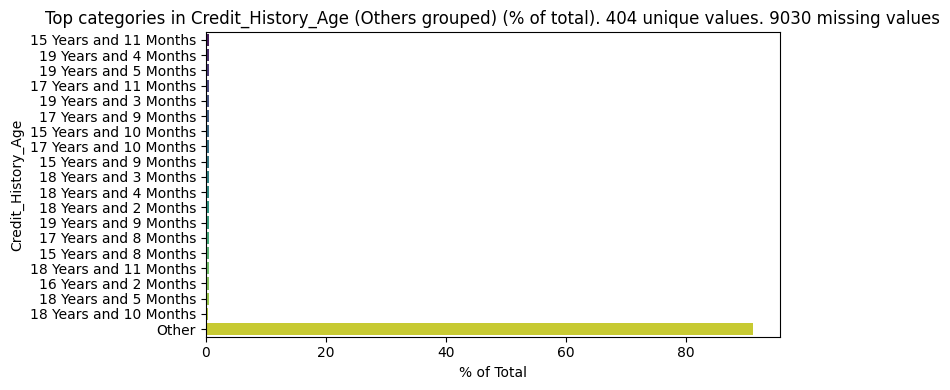

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


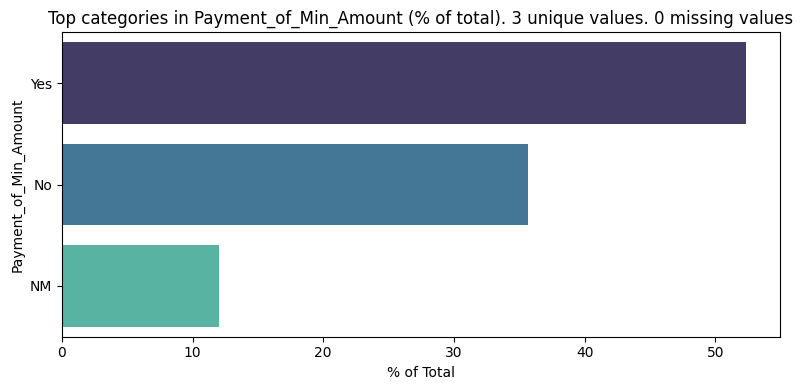

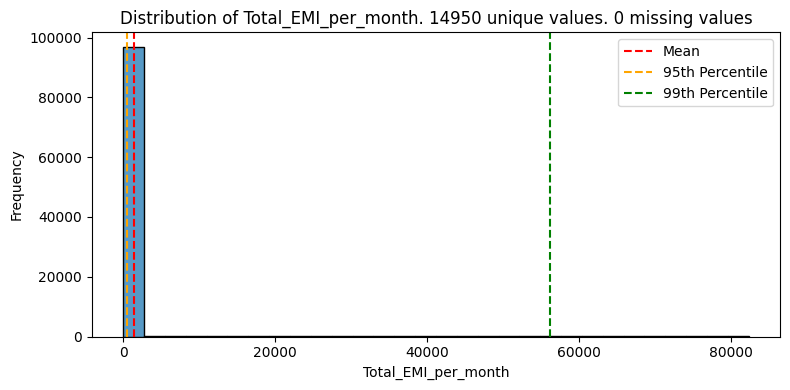

<Figure size 640x480 with 0 Axes>

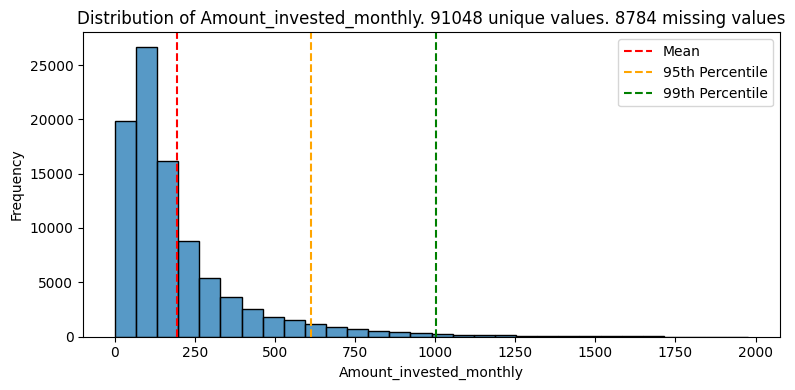

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


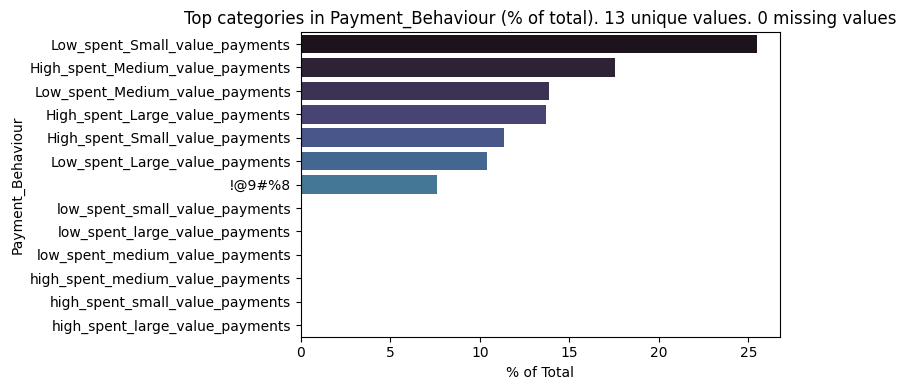

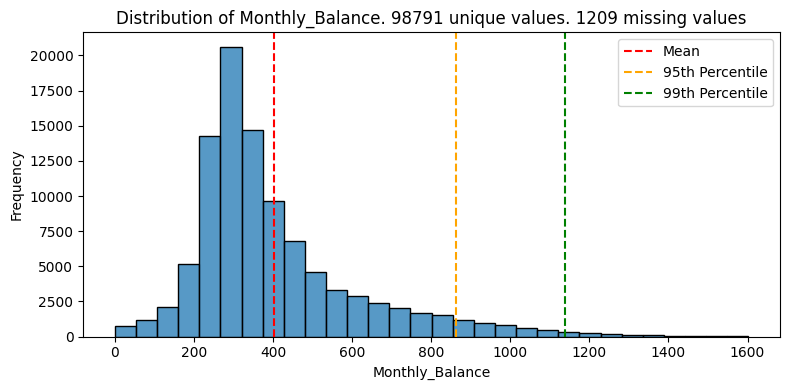

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


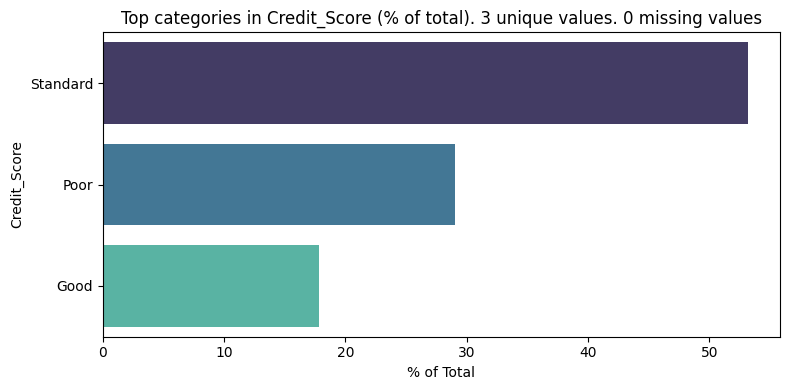

In [259]:
# With the data with correct data types and with some cleaning having started, we can start visualizing the variables
for variable in dataset.columns:
    plt.figure(figsize=(8, 4))

    num_unique = dataset[variable].nunique()
    num_missing = dataset[variable].isnull().sum()

    if variable in numerical_variables: # Numerical variables

        summary_stats = dataset[variable].describe(percentiles=[0.95, 0.99]).transpose()
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        sns.histplot(dataset[variable], bins=30)
        plt.axvline(mean, color='red', linestyle='--', label='Mean')
        plt.axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        plt.axvline(p99, color='green', linestyle='--', label='99th Percentile')

        plt.title(f'Distribution of {variable}. {num_unique} unique values. {num_missing} missing values')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif variable in categorical_variables and dataset[variable].nunique() <= 20:
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)

    elif variable in categorical_variables:
        # Calculate percentage distribution for all categories
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)


    plt.tight_layout()
    plt.show()


# Feature Engineering

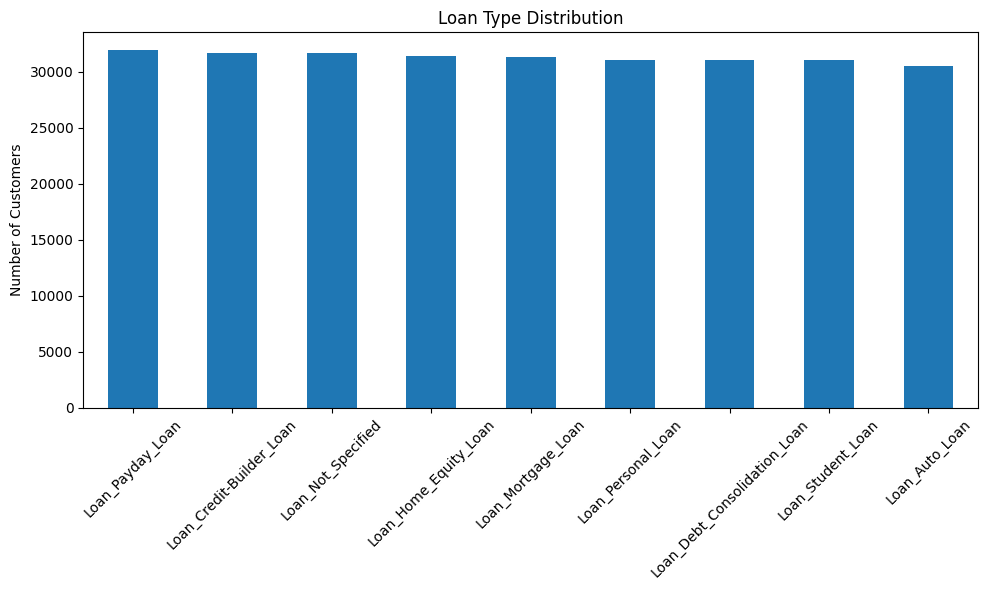

In [260]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Clean and split the loan strings
loans = (
    dataset['Type_of_Loan'].fillna('')
       .str.replace(r'\s+and\s+', ',', regex=True)
       .str.replace(r',+', ',', regex=True)
       .str.strip(' ,')
)
loan_lists = loans.str.split(',').apply(lambda toks: [t.strip() for t in toks if t.strip()])

# 2. Multi-hot encode
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(
    mlb.fit_transform(loan_lists),
    columns=['Loan_' + c.replace(' ', '_').title() for c in mlb.classes_],
    index=dataset.index
)

# 3. Merge and drop original
dataset = pd.concat([dataset, dummies], axis=1).drop(columns=['Type_of_Loan'])

# 4. Plot distribution
counts = dummies.sum().sort_values(ascending=False)
counts.plot.bar(figsize=(10,6), rot=45, title='Loan Type Distribution')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


In [261]:
dummies = mlb.classes_.tolist()
print(dummies)

['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']


In [262]:
# Debt-to-Income
dataset['DTI'] = dataset['Outstanding_Debt'] / dataset['Annual_Income']

# EMI-to-Income
dataset['EMI_Ratio'] = dataset['Total_EMI_per_month'] / dataset['Monthly_Inhand_Salary']

dataset['log_OutDebt']   = np.log1p(dataset['Outstanding_Debt'])
dataset['log_AnnIncome'] = np.log1p(dataset['Annual_Income'])
dataset['log_EMI']       = np.log1p(dataset['Total_EMI_per_month'])

# binning
# Age buckets
bins_age = [0, 25, 35, 50, dataset['Age'].max()]
labels_age = ['0-25','26-35','36-50','51+']
dataset['Age_Group'] = pd.cut(dataset['Age'], bins=bins_age, labels=labels_age)

# Income quartiles
dataset['Income_Quartile'] = pd.qcut(dataset['Annual_Income'], q=4, labels=False) + 1

# Credit history length

# Converting credit_history_age to months

def extract_months(value):
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r'\d+', value)
    if not numbers:
        return np.nan
    years = int(numbers[0]) if len(numbers) > 0 else 0
    months = int(numbers[1]) if len(numbers) > 1 else 0
    return years * 12 + months


dataset['Credit_History_Age'] = dataset['Credit_History_Age'].apply(extract_months)


# 1) Convert Credit_History_Age (in months) from object to numeric
dataset['Credit_History_Age'] = pd.to_numeric(
    dataset['Credit_History_Age'], 
    errors='coerce'
)

# 2) Define bins
bins_hist   = [0, 100, 300, 999]
labels_hist = ['Short', 'Medium', 'Long']

# 3) Apply pd.cut with those bins
dataset['History_Length'] = pd.cut(
    dataset['Credit_History_Age'],
    bins=bins_hist,
    labels=labels_hist,
    right=False     # so that exactly 24→Medium, 60→Long
)

In [263]:
dataset.drop(['ID', 'Customer_ID', 'Name', 'SSN', ], axis=1, inplace=True)
# I'm dropping type of loan just for the sake of not adding complexity now


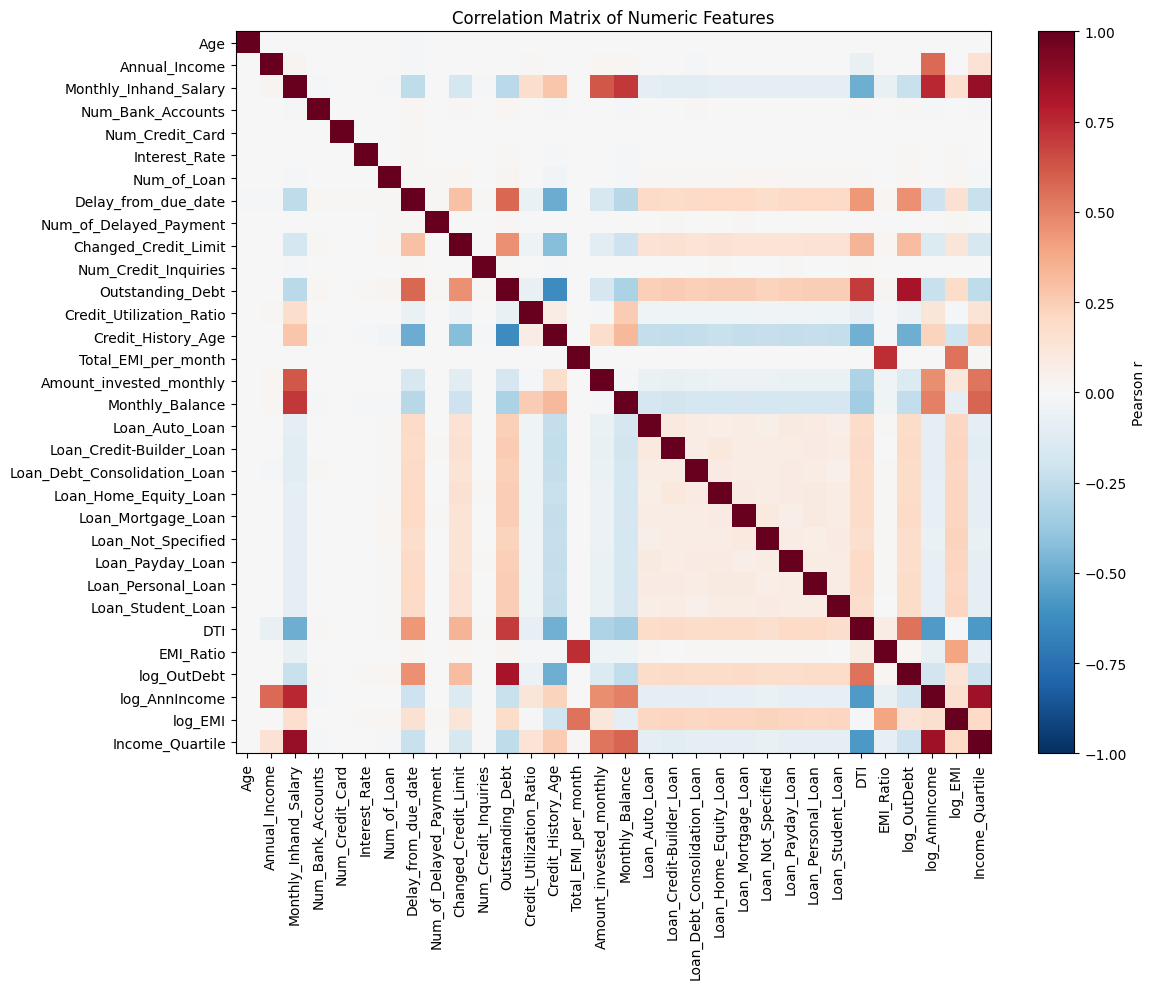

Highly correlated feature pairs (|r| > 0.7):
               feature_1              feature_2      corr
0        Income_Quartile  Monthly_Inhand_Salary  0.871728
1        Income_Quartile          log_AnnIncome  0.845090
2       Outstanding_Debt            log_OutDebt  0.823493
3  Monthly_Inhand_Salary          log_AnnIncome  0.751941
4              EMI_Ratio    Total_EMI_per_month  0.741065
5        Monthly_Balance  Monthly_Inhand_Salary  0.704899


In [264]:
# 1. Grab just the numeric features (so categorical cuts like Age_Group/History_Length are excluded)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

# 2. Compute the Pearson correlation matrix
corr = dataset[numeric_cols].corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(np.arange(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(np.arange(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# 4. Extract all unique feature‐pairs with |r| > 0.7
corr_pairs = (
    corr
      .abs()                          # absolute correlations
      .unstack()                      # long form
      .reset_index(name='corr')       # name the new column
)
corr_pairs.columns = ['feature_1', 'feature_2', 'corr']

# filter out self‐pairs and duplicates (A,B vs B,A)
strong_pairs = (
    corr_pairs[
        (corr_pairs['feature_1'] < corr_pairs['feature_2']) &
        (corr_pairs['corr'] > 0.7)
    ]
    .sort_values('corr', ascending=False)
    .reset_index(drop=True)
)

print("Highly correlated feature pairs (|r| > 0.7):")
print(strong_pairs)

# Modelling

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

data = dataset.copy()
# Separate features and target
target_col = 'Credit_Score' 
X = data.drop(columns=[target_col]).copy()

# Explicit category order
encoder = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])

# Must be 2D input
y = data[[target_col]].copy()
y[target_col] = encoder.fit_transform(y[[target_col]]).astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test  distribution:\n", y_test.value_counts(normalize=True))


Train distribution:
 Credit_Score
1               0.531743
0               0.289986
2               0.178271
Name: proportion, dtype: float64
Test  distribution:
 Credit_Score
1               0.531733
0               0.289967
2               0.178300
Name: proportion, dtype: float64


In [266]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Month                         100000 non-null  object  
 1   Age                           94974 non-null   float64 
 2   Occupation                    99909 non-null   object  
 3   Annual_Income                 92932 non-null   float64 
 4   Monthly_Inhand_Salary         84920 non-null   float64 
 5   Num_Bank_Accounts             99909 non-null   float64 
 6   Num_Credit_Card               99909 non-null   float64 
 7   Interest_Rate                 99909 non-null   float64 
 8   Num_of_Loan                   95127 non-null   float64 
 9   Delay_from_due_date           100000 non-null  int64   
 10  Num_of_Delayed_Payment        90254 non-null   float64 
 11  Changed_Credit_Limit          97909 non-null   float64 
 12  Num_Credit_Inquiries          9

In [267]:
X.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Loan_Auto_Loan,Loan_Credit-Builder_Loan,Loan_Debt_Consolidation_Loan,Loan_Home_Equity_Loan,Loan_Mortgage_Loan,Loan_Not_Specified,Loan_Payday_Loan,Loan_Personal_Loan,Loan_Student_Loan,DTI,EMI_Ratio,log_OutDebt,log_AnnIncome,log_EMI,Income_Quartile
count,94974.000000,9.293200e+04,84920.000000,99909.000000,99909.000000,99909.000000,95127.000000,100000.000000,90254.000000,97909.000000,98035.000000,98991.000000,100000.000000,90970.000000,100000.000000,91216.000000,98791.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,9.199300e+04,84920.000000,98991.000000,92932.000000,100000.000000,92932.000000
mean,110.863615,1.784985e+05,4194.071131,17.104395,22.495621,72.469027,2.781765,21.068780,31.027777,10.389025,27.754251,1426.503700,32.285173,221.195405,1403.118217,195.539456,402.551258,0.305300,0.316980,0.310120,0.313690,0.313340,0.316520,0.31915,0.310720,0.310120,6.006215e-02,0.604822,6.848876,10.592144,4.102308,2.499903
std,689.228869,1.443061e+06,3183.605038,117.454091,129.115463,466.383442,62.528021,14.860104,226.956479,6.789496,193.177339,1155.045753,5.116875,99.741364,8306.041270,199.564527,213.925499,0.460537,0.465302,0.462545,0.463994,0.463854,0.465121,0.46615,0.462791,0.462545,8.724512e-02,4.979210,1.083137,0.967540,1.963146,1.118098
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,-100.000000,-5.000000,-27.000000,-6.490000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.086800e-07,0.000000,0.207014,8.854655,0.000000,1.000000
25%,24.000000,1.943628e+04,1625.597917,3.000000,4.000000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.080000,28.052567,144.000000,30.306660,72.236692,270.106630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,9.252035e-03,0.012618,6.340500,9.874948,3.443831,1.000000
50%,33.000000,3.755074e+04,3093.745000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.370000,32.305784,219.000000,69.249473,128.954538,336.731225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.776677e-02,0.025243,7.062509,10.533475,4.252053,2.000000
75%,42.000000,7.284338e+04,5957.448333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1948.200000,36.496663,302.000000,161.224249,236.815814,470.262938,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.908371e-02,0.042684,7.575174,11.196081,5.088980,3.250000
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,404.000000,82331.000000,1977.326102,1602.040519,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.832516e-01,227.739318,8.517007,17.001783,11.318515,4.000000


In [268]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_features = ["Credit_Mix", "Age_Group", "History_Length"]
nominal_features = [col for col in categorical_features if col not in ordinal_features and col not in dummies]
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

credit_mix_order    = ["bad", "standard", "good"]
age_group_order     = ["0-25", "26-35", "36-45",  "51+"]
history_length_order = ["Short", "Medium", "Long"]

ordinal_categories = [
    credit_mix_order,
    age_group_order,
    history_length_order,
]

In [269]:
def correct_month(month_str):
    # Define the canonical month names.
    canonical_months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    # Clean the input string.
    candidate = month_str.strip().lower()
    
    # Find the closest match (using a cutoff for similarity).
    matches = difflib.get_close_matches(candidate, [m.lower() for m in canonical_months], n=1, cutoff=0.6)
    
    if matches:
        # Return the canonical name matching the found close match.
        for m in canonical_months:
            if m.lower() == matches[0]:
                return m
    else:
        # Fallback: return the original string capitalized.
        return month_str.capitalize()

In [270]:
def business_logic_limits(df, column, lower_limit, upper_limit):
    """
    Replace values below lower_limit with NaN and values above upper_limit with NaN.
    
    Parameters:
    - df: DataFrame containing the data
    - column: The column name where outliers should be replaced with NaN
    - lower_limit: The minimum allowed value for the column
    - upper_limit: The maximum allowed value for the column
    
    Returns:
    - DataFrame with outliers replaced by NaN
    """
    # Replace values below the lower limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x < lower_limit else x)
    
    # Replace values above the upper limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x > upper_limit else x)
    
    return df


In [271]:
def winsorize_by_iqr(df, column, lower_threshold_factor=3, upper_threshold_factor=3):
    """
    Apply winsorization to a column in the DataFrame based on the IQR (Interquartile Range) method.
    Values below the lower threshold are replaced by the lower threshold and values above the upper
    threshold are replaced by the upper threshold.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: The column name to apply winsorization on.
    - lower_threshold_factor: The factor to calculate the lower threshold. Default is 1.5 (commonly used).
    - upper_threshold_factor: The factor to calculate the upper threshold. Default is 1.5 (commonly used).
    
    Returns:
    - df: DataFrame with winsorized values.
    """
    
    # Calculate the IQR (Interquartile Range)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    p95 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds based on the IQR method
    lower_bound = Q1 - lower_threshold_factor * IQR
    upper_bound = min(p95, Q3 + upper_threshold_factor * IQR)
    
    # Apply winsorization: cap values that are below the lower bound or above the upper bound
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    
    return df

In [272]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self, cleaning_rules, lower_threshold_factor=3, upper_threshold_factor=3):
        self.cleaning_rules = cleaning_rules
        self.lower_threshold_factor = lower_threshold_factor
        self.upper_threshold_factor = upper_threshold_factor
        self._winsor_bounds = {}
        self.allow_underscore = ['Payment_Behaviour']

    def fit(self, X, y=None):
        self._winsor_bounds = {}
        for variable in X.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                if rule.get('nonsense_outliers', False):
                    col = X[variable]
                    Q1 = col.quantile(0.25)
                    Q3 = col.quantile(0.75)
                    p95 = col.quantile(0.95)
                    IQR = Q3 - Q1
                    lower = Q1 - self.lower_threshold_factor * IQR
                    upper = min(p95, Q3 + self.upper_threshold_factor * IQR)
                    self._winsor_bounds[variable] = (lower, upper)
        return self

    def transform(self, X):
        cleaned_data = X.copy()
        # Apply underscore removal to all object columns except those in allow_underscore
        for col in cleaned_data.columns:
            if cleaned_data[col].dtype == 'object' and col not in self.allow_underscore:
                cleaned_data[col] = cleaned_data[col].astype(str).str.replace("_", "", regex=False)
            if col == "Month":
                cleaned_data["Month"] = cleaned_data["Month"].apply(correct_month)
        
        # Then apply other cleaning rules
        for variable in cleaned_data.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                # Apply business logic limits if needed
                if rule.get("is_numeric", False) and rule.get("business_logic", False):
                    min_val = rule.get("business_logic_min", None)
                    max_val = rule.get("business_logic_max", None)
                    business_logic_limits(cleaned_data, variable, min_val, max_val)
                # Apply winsorization using stored bounds
                if rule.get("nonsense_outliers", False):
                    bounds = self._winsor_bounds.get(variable, None)
                    if bounds is not None:
                        lower, upper = bounds
                        cleaned_data[variable] = cleaned_data[variable].apply(
                            lambda x: lower if x < lower else (upper if x > upper else x)
                        )
        return cleaned_data

In [273]:
cleaning_rules = {
    "ID": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": True,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Customer_ID": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Month": {
        "is_numeric": False,
        "business_logic": True,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Name": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Age": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": True,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "SSN": {
        "is_numeric": False,
        "business_logic": True,
        "all_values_unique": True,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Occupation": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": False,
    },
    "Annual_Income": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 10000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "logical_value_substitution": True,
        "sequence_by_step": False,
        "nonsense_outliers": True,
    },
    "Monthly_Inhand_Salary": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Bank_Accounts": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Credit_Card": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Interest_Rate": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Loan": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Type_of_Loan": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Delay_from_due_date": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 365,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Delayed_Payment": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Changed_Credit_Limit": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Num_Credit_Inquiries": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Credit_Mix": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Outstanding_Debt": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_Utilization_Ratio": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0.0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_History_Age": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_value_filling": None,
        "single_change": False,
        "sequence_by_step": True,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Payment_of_Min_Amount": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Total_EMI_per_month": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 200000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Amount_invested_monthly": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Payment_Behaviour": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Monthly_Balance": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Credit_Score": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    }
}


In [274]:
X_train_copy = X_train.copy()
X_train_copy.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Loan_Auto_Loan,Loan_Credit-Builder_Loan,Loan_Debt_Consolidation_Loan,Loan_Home_Equity_Loan,Loan_Mortgage_Loan,Loan_Not_Specified,Loan_Payday_Loan,Loan_Personal_Loan,Loan_Student_Loan,DTI,EMI_Ratio,log_OutDebt,log_AnnIncome,log_EMI,Age_Group,Income_Quartile,History_Length
20302,July,22.0,Journalist,19386.02,1858.501667,4.0,4.0,7.0,3.0,5,15.0,9.74,11.0,_,2438.26,33.977238,179.0,Yes,40.009251,138.276380,Low_spent_Small_value_payments,297.564536,0,1,0,0,0,0,1,0,1,0.125774,0.021528,7.799450,9.872359,3.713798,0-25,1.0,Medium
54150,July,NaN,Journalist,162590.56,13535.213333,5.0,6.0,11.0,0.0,25,6.0,11.65,4.0,Good,1000.11,29.354953,NaN,No,0.000000,617.724289,Low_spent_Medium_value_payments,1015.797045,0,0,0,0,0,0,0,0,0,0.006151,0.000000,6.908865,11.998997,0.000000,NaN,4.0,NaN
27701,June,45.0,Lawyer,NaN,1253.378333,3.0,4.0,13.0,1.0,9,11.0,11.84,0.0,_,927.98,31.342164,338.0,Yes,12.567581,109.047020,Low_spent_Small_value_payments,293.723233,0,1,0,0,0,0,0,0,0,NaN,0.010027,6.834087,NaN,2.607683,36-50,NaN,Long
15179,April,31.0,Entrepreneur,59050.48,5018.873333,8.0,8.0,28.0,9.0,56,22.0,19.29,10.0,Bad,4283.98,30.657677,26.0,Yes,339.495329,110.415542,High_spent_Medium_value_payments,301.976463,0,0,0,1,1,1,1,0,1,0.072548,0.067644,8.362871,10.986165,5.830401,26-35,3.0,Short
35630,July,NaN,Entrepreneur,93390.44,7538.536667,6.0,5.0,18.0,3.0,29,12.0,11.28,0.0,Standard,1036.26,28.404034,NaN,No,117.487162,758.409188,Low_spent_Small_value_payments,167.957317,0,0,1,0,0,0,0,1,0,0.011096,0.015585,6.944338,11.444555,4.774805,NaN,4.0,NaN


C:\Users\desou\AppData\Local\Temp\ipykernel_8684\931144989.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


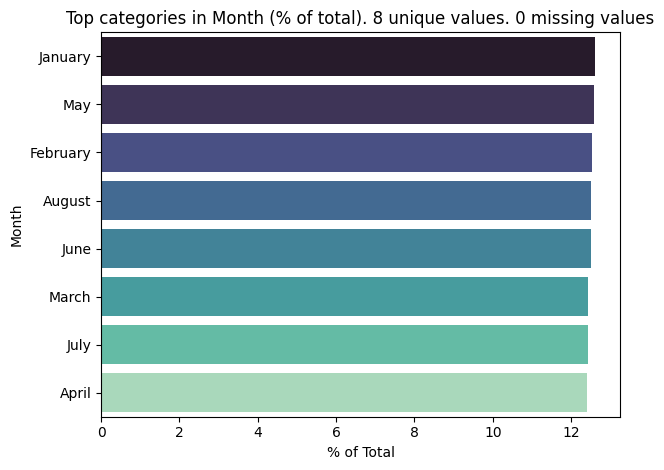

count    64562.000000
mean        33.229516
std         10.677681
min         14.000000
50%         33.000000
95%         52.000000
99%         53.000000
max         53.000000
Name: Age, dtype: float64


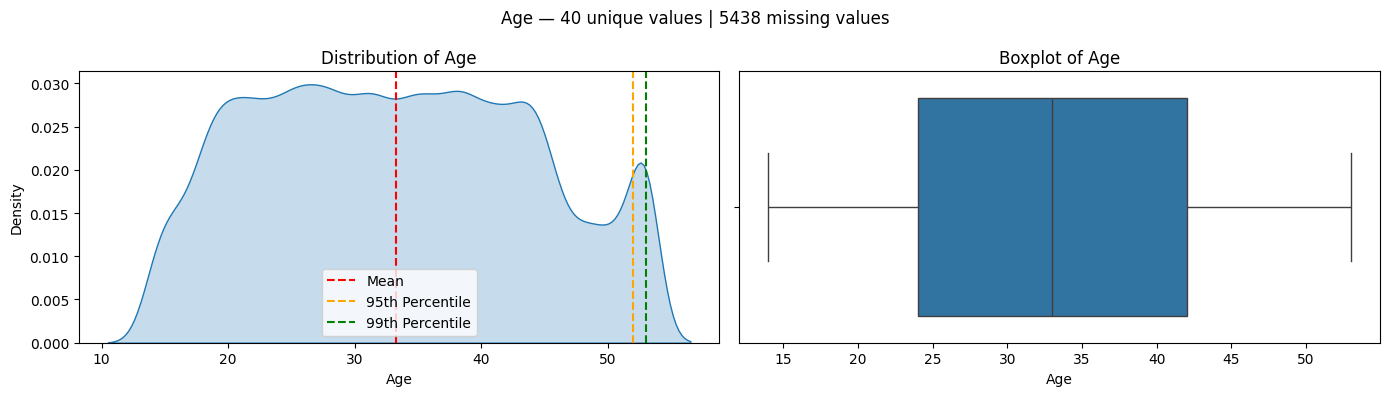

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\931144989.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


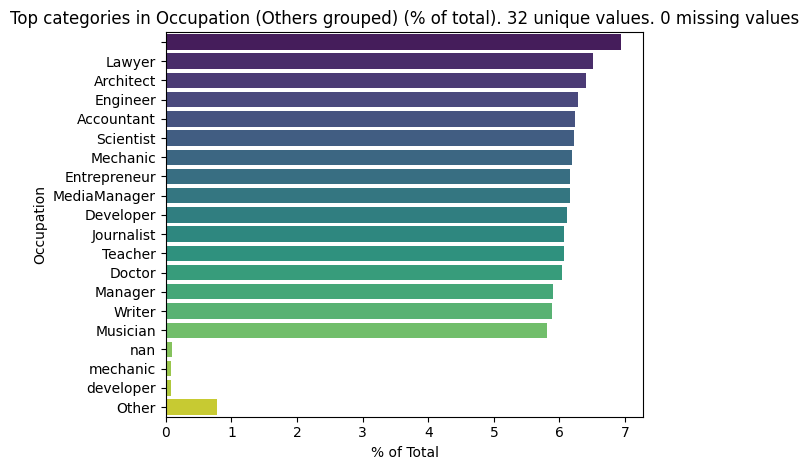

count     64631.000000
mean      49994.112037
std       36605.126779
min        7005.930000
50%       37045.780000
95%      131990.840000
99%      134734.160000
max      134734.160000
Name: Annual_Income, dtype: float64


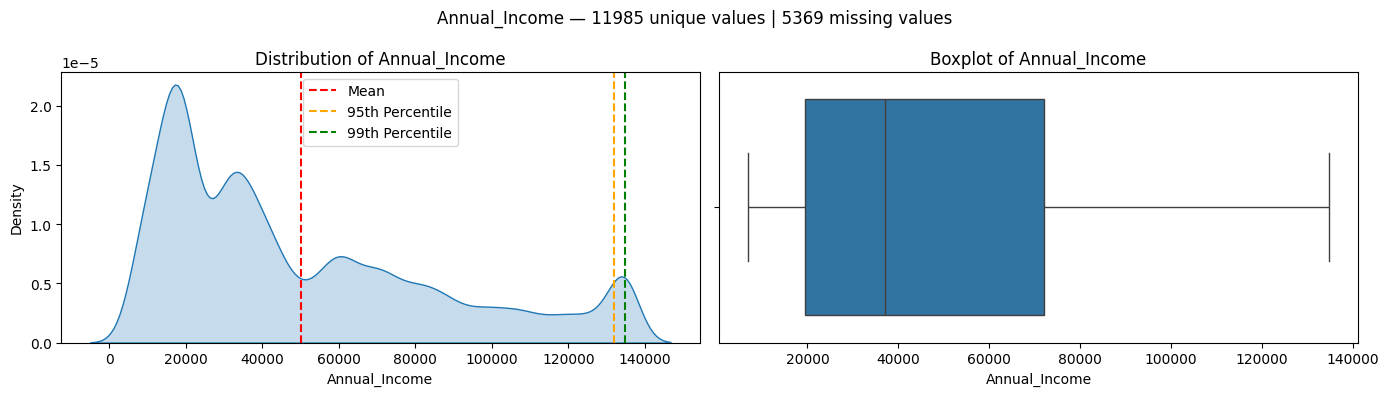

count    59469.000000
mean      4109.217890
std       2979.938825
min        303.645417
50%       3084.106667
95%      10841.770267
99%      10841.832667
max      10841.832667
Name: Monthly_Inhand_Salary, dtype: float64


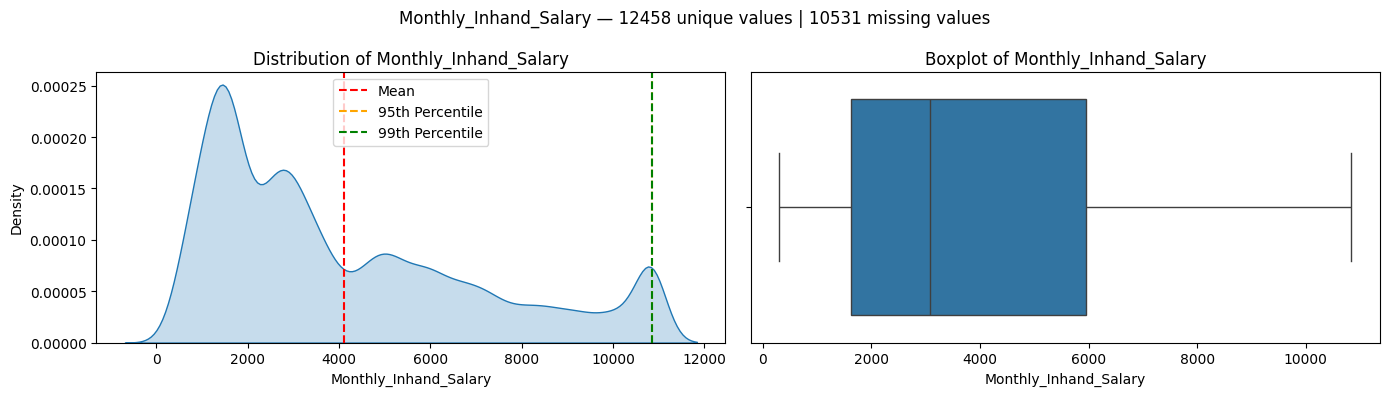

count    68986.000000
mean         5.371583
std          2.588731
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Bank_Accounts, dtype: float64


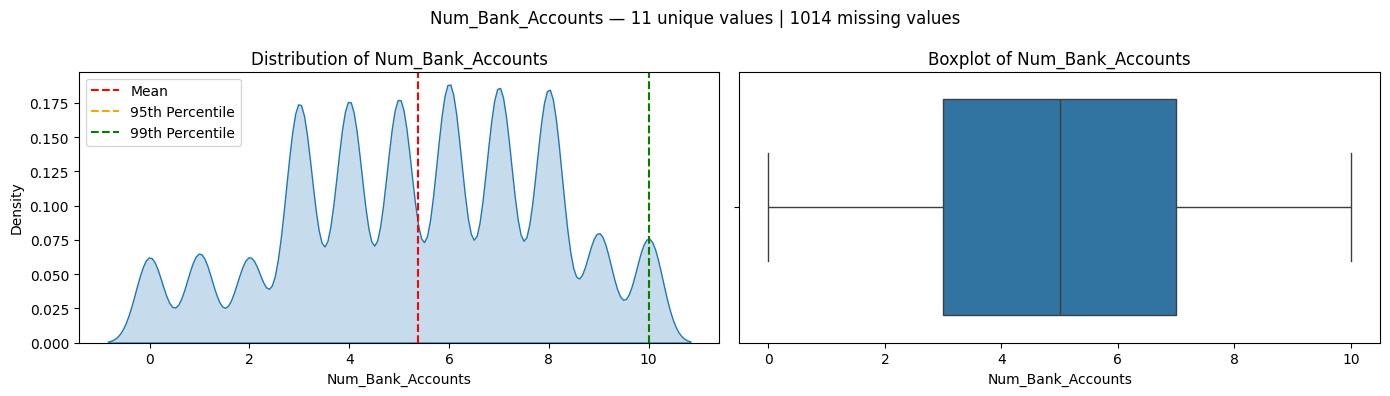

count    68373.000000
mean         5.534275
std          2.067581
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Credit_Card, dtype: float64


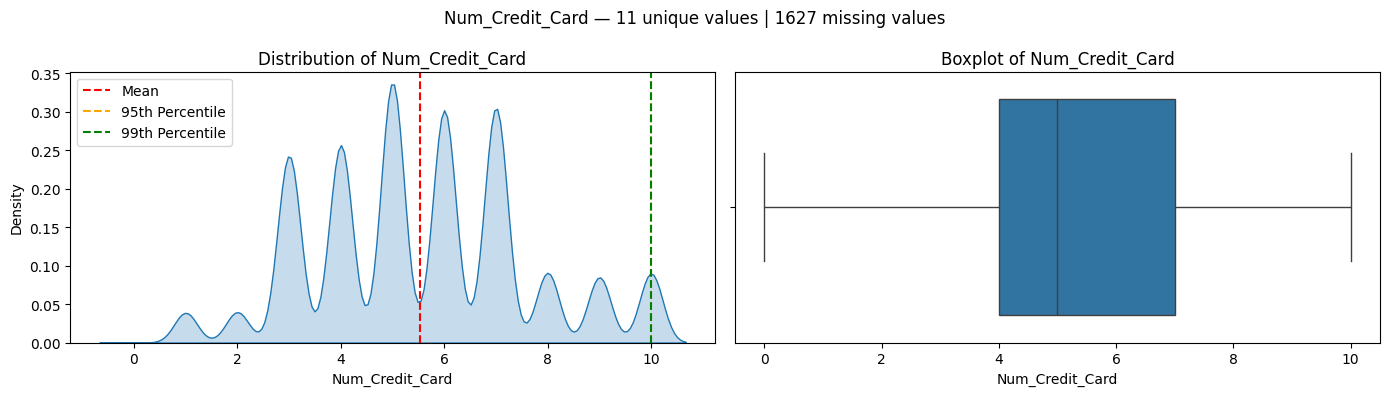

count    68521.000000
mean        14.489850
std          8.642414
min          1.000000
50%         13.000000
95%         31.000000
99%         32.000000
max         32.000000
Name: Interest_Rate, dtype: float64


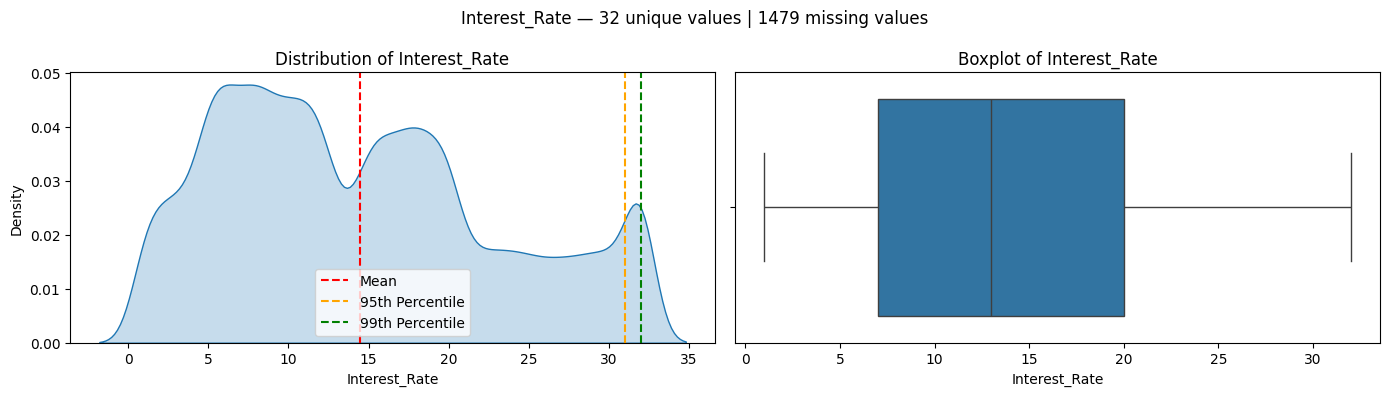

count    63623.000000
mean         3.502743
std          2.366419
min          0.000000
50%          3.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: Num_of_Loan, dtype: float64


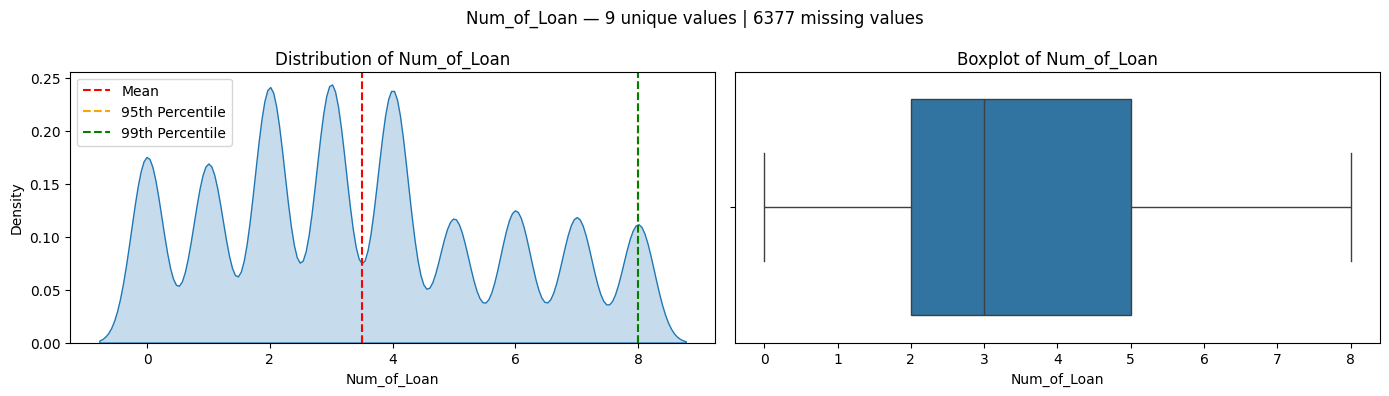

count    69574.000000
mean        21.004729
std         14.253455
min          0.000000
50%         18.000000
95%         54.000000
99%         54.000000
max         54.000000
Name: Delay_from_due_date, dtype: float64


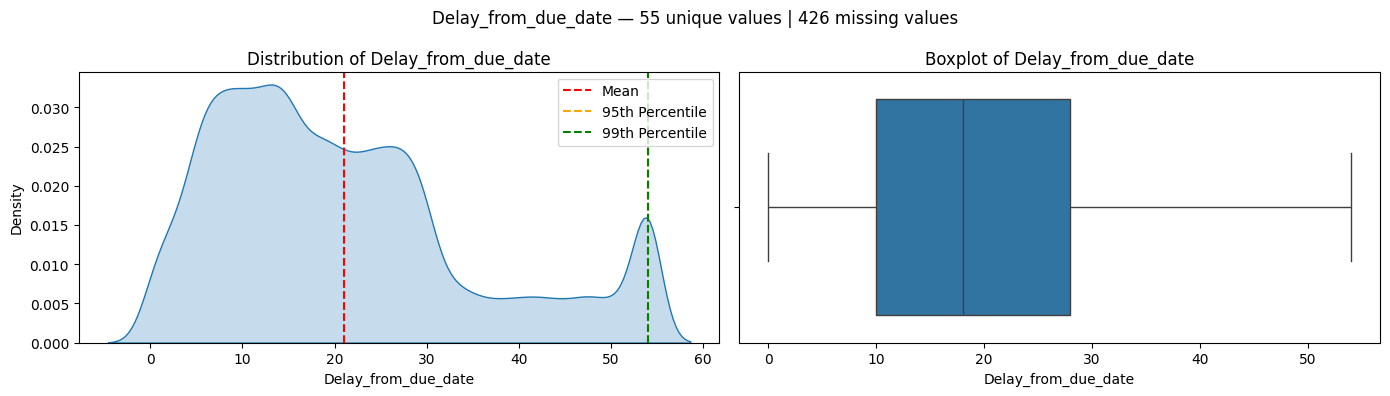

count    62239.000000
mean        13.413953
std          6.135682
min          0.000000
50%         14.000000
95%         23.000000
99%         24.000000
max         24.000000
Name: Num_of_Delayed_Payment, dtype: float64


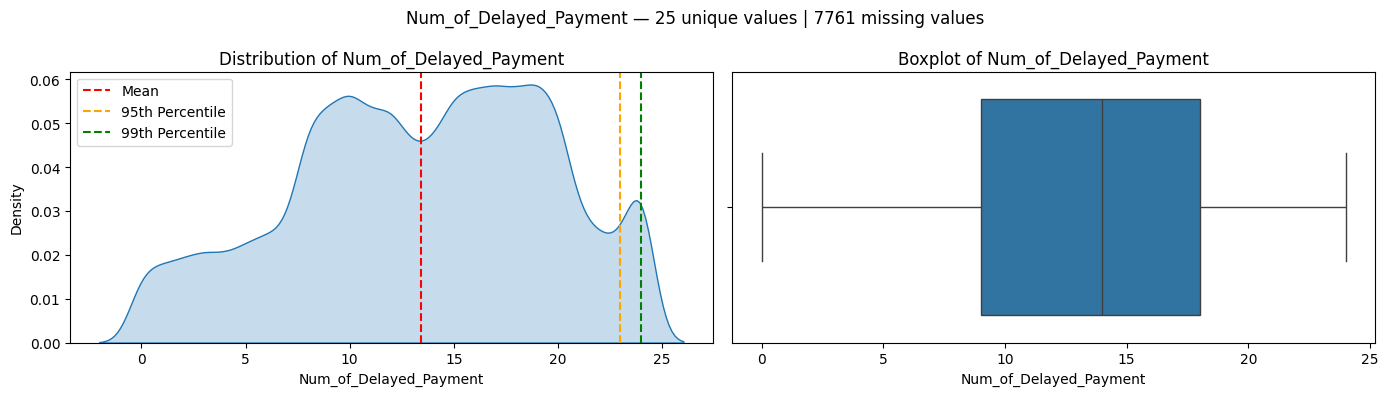

count    68500.000000
mean        10.390668
std          6.795325
min         -6.490000
50%          9.400000
95%         23.670500
99%         28.830000
max         36.970000
Name: Changed_Credit_Limit, dtype: float64


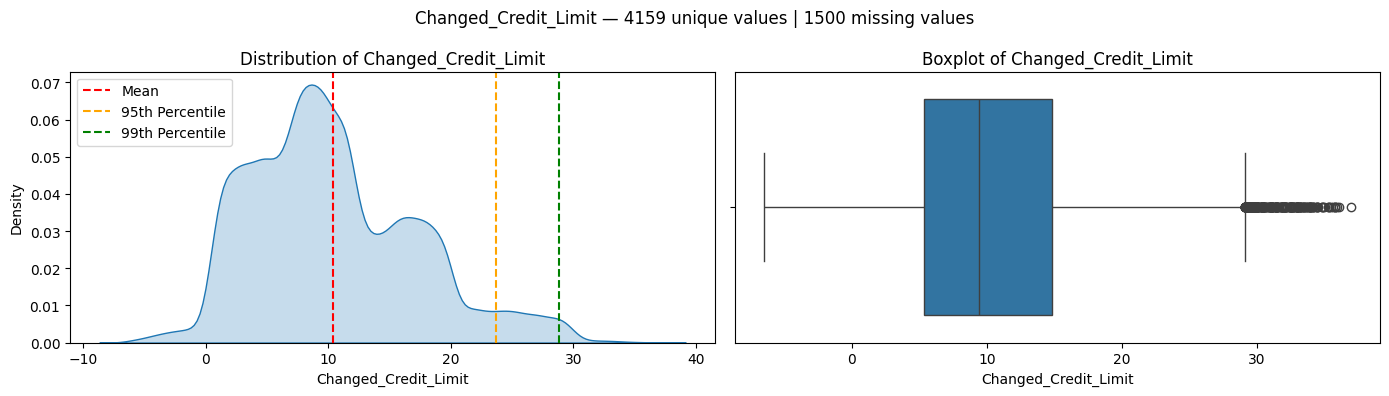

count    67497.000000
mean         5.734003
std          3.741955
min          0.000000
50%          5.000000
95%         12.000000
99%         13.000000
max         13.000000
Name: Num_Credit_Inquiries, dtype: float64


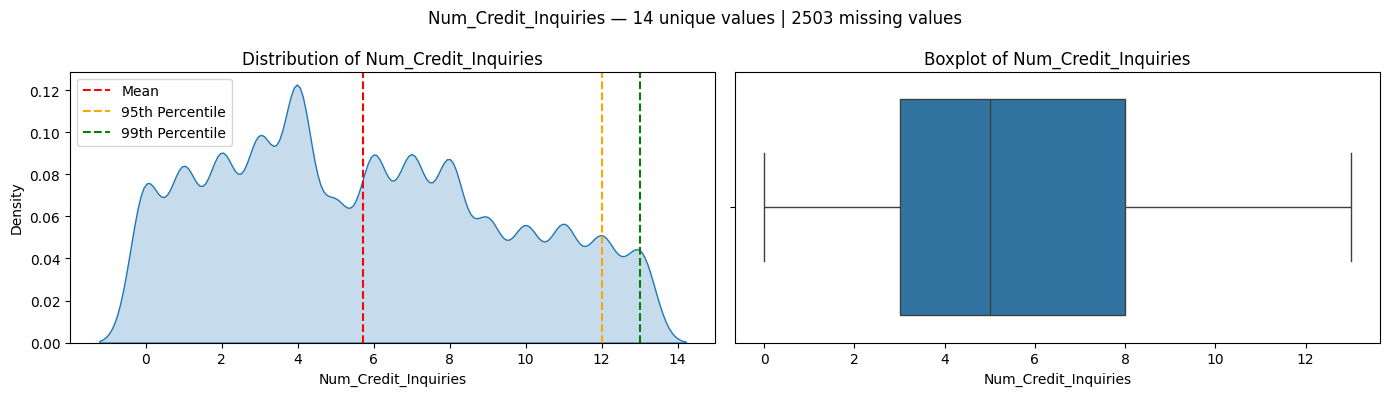

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\931144989.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


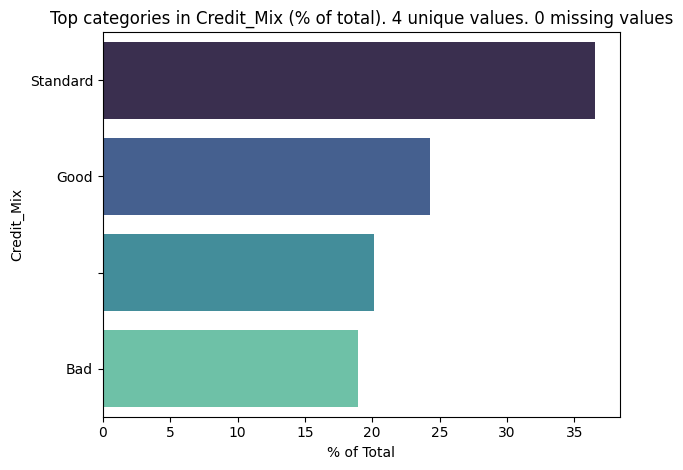

count    69299.000000
mean      1428.165649
std       1156.567299
min          0.230000
50%       1166.910000
95%       4085.140000
99%       4801.094800
max       4998.070000
Name: Outstanding_Debt, dtype: float64


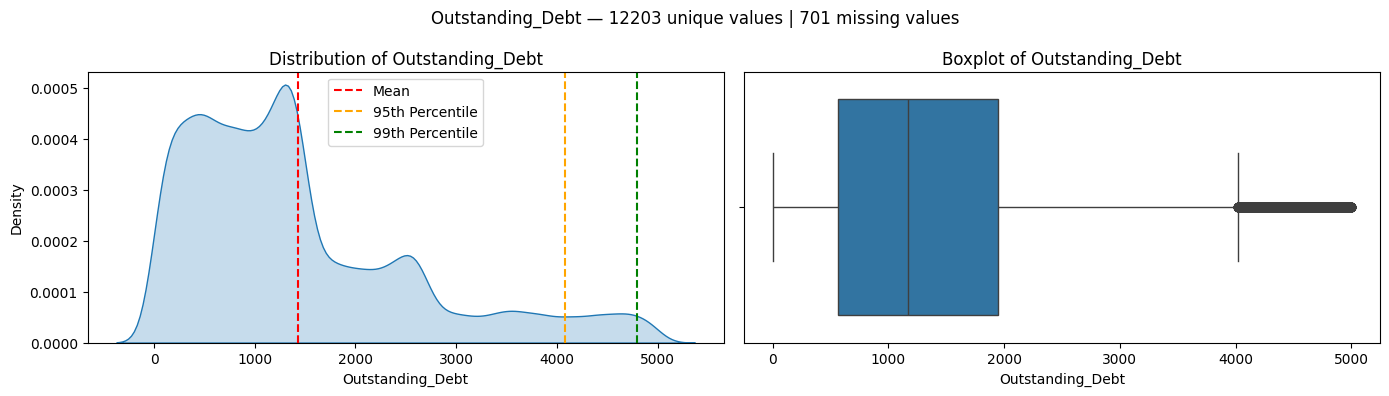

count    70000.000000
mean        32.274543
std          5.118649
min         20.000000
50%         32.298463
95%         40.209639
99%         42.449940
max         50.000000
Name: Credit_Utilization_Ratio, dtype: float64


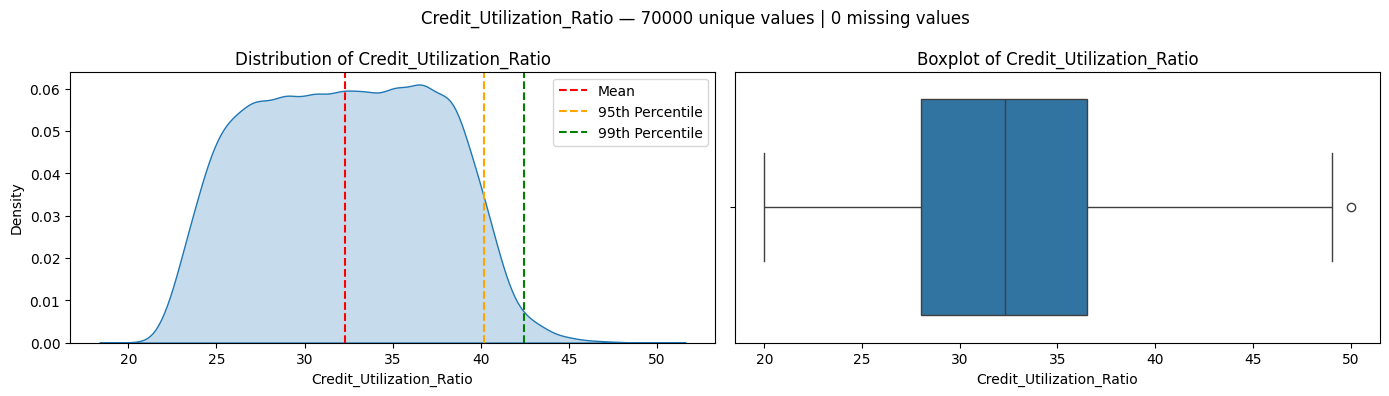

count    63663.000000
mean       221.245150
std         99.807095
min          1.000000
50%        220.000000
95%        382.000000
99%        396.000000
max        404.000000
Name: Credit_History_Age, dtype: float64


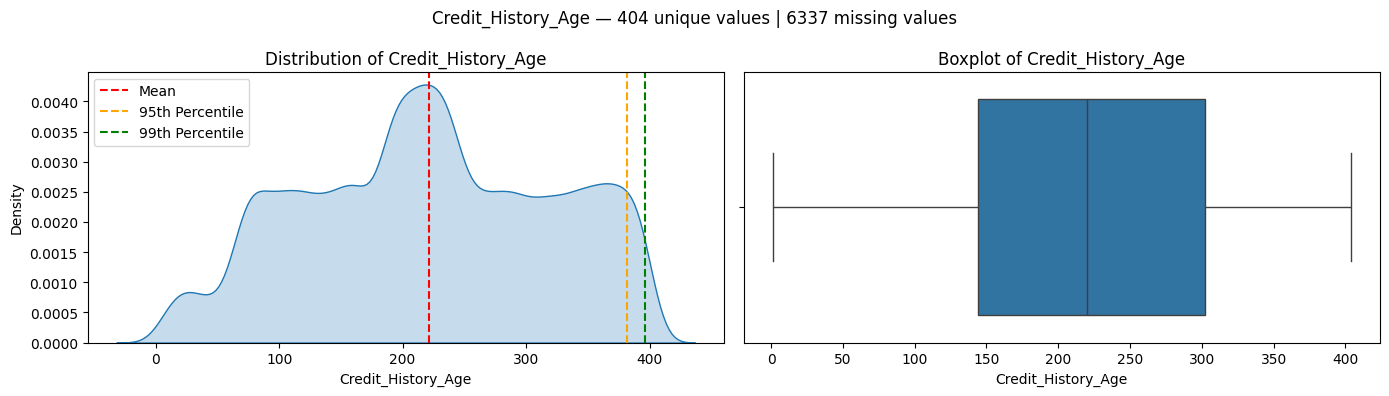

C:\Users\desou\AppData\Local\Temp\ipykernel_8684\931144989.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


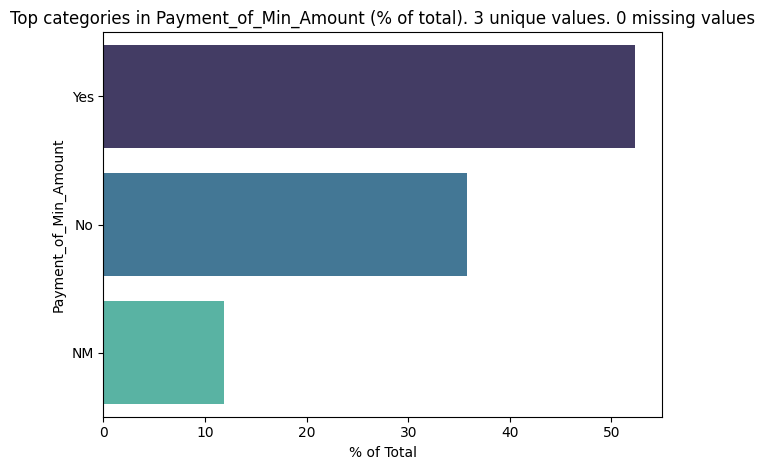

count    70000.000000
mean       112.354169
std        115.551289
min          0.000000
50%         69.055656
95%        432.521330
99%        432.521541
max        432.521541
Name: Total_EMI_per_month, dtype: float64


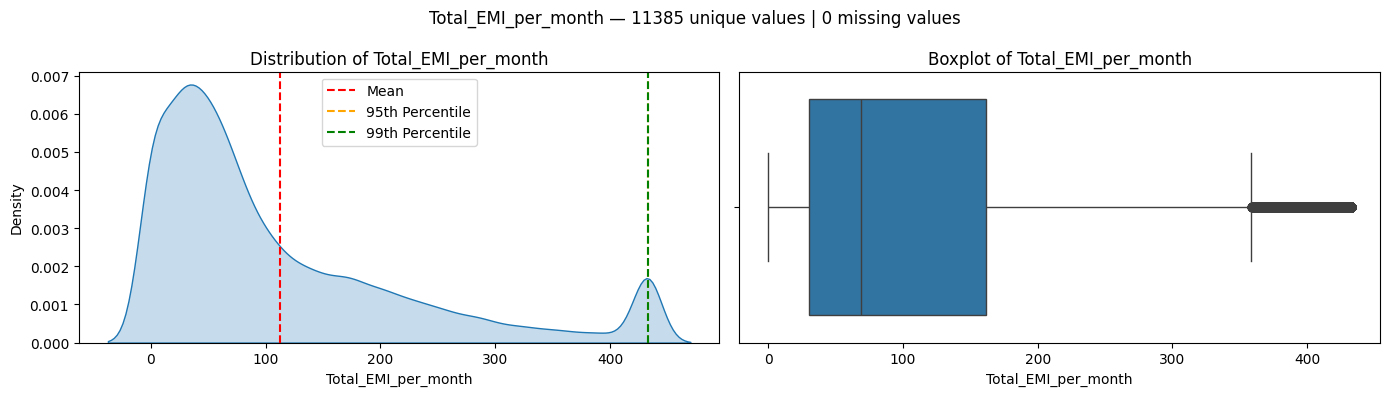

count    63855.000000
mean       183.995639
std        157.817712
min          0.000000
50%        128.952103
95%        612.918247
99%        612.959222
max        612.959222
Name: Amount_invested_monthly, dtype: float64


In [ ]:

X_train_copy = X_train.copy()
data_to_visualize = DataCleaning(cleaning_rules).fit_transform(X_train_copy)

for variable in data_to_visualize.columns:

    num_unique = data_to_visualize[variable].nunique()
    num_missing = data_to_visualize[variable].isnull().sum()

    if data_to_visualize[variable].dtype in ['float64', 'int64'] and variable not in dummies:
        summary_stats = data_to_visualize[variable].describe(percentiles=[0.95, 0.99]).transpose()
        print(summary_stats)
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sns.kdeplot(data=data_to_visualize, x=variable, ax=axes[0], fill=True)
        axes[0].axvline(mean, color='red', linestyle='--', label='Mean')
        axes[0].axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        axes[0].axvline(p99, color='green', linestyle='--', label='99th Percentile')
        axes[0].set_title(f'Distribution of {variable}')
        axes[0].set_xlabel(variable)
        axes[0].set_ylabel('Density')
        axes[0].legend()

        # Boxplot
        sns.boxplot(data=data_to_visualize, x=variable, ax=axes[1], orient='h')
        axes[1].set_title(f'Boxplot of {variable}')
        axes[1].set_xlabel(variable)

        fig.suptitle(f'{variable} — {num_unique} unique values | {num_missing} missing values', fontsize=12)
        plt.tight_layout()
        plt.show()

    elif variable in dummies:
        sns.barplot(x=value_counts.index.map({0: 'No', 1: 'Yes'}), y=value_counts.values, palette='mako')
        plt.title('Distribution of Dummy Variable: variable')
        plt.ylabel('% of Total')
        plt.xlabel(variable)
        plt.tight_layout()
        plt.show()


    elif data_to_visualize[variable].dtype not in ['float64', 'int64'] and data_to_visualize[variable].nunique() <= 20:
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    elif data_to_visualize[variable].dtype not in ['float64', 'int64']:
        # Calculate percentage distribution for all categories
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    


In [116]:
models = {
    'logistic_regression': {
        'estimator': LogisticRegression(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear'],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__max_iter': [100, 200, 500]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'decision_tree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'parameter_grid': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': True,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'random_forest': {
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__max_features': ['sqrt'],
            'classifier__bootstrap': [True],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'gradient_boosting': {
        'estimator': GradientBoostingClassifier(random_state=42),
        'parameter_grid': {
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 3],
            'classifier__subsample': [0.8, 1.0],
            'classifier__max_features': ['sqrt', 0.8]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'xgboost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
        'parameter_grid': {
            'classifier__n_estimators': [100, 300],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__min_child_weight': [1, 5],
            'classifier__subsample': [0.8],
            'classifier__colsample_bytree': [0.8],
            'classifier__scale_pos_weight': [1, 5]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': True
    },
    'lightgbm': {
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__num_leaves': [31, 50],
            'classifier__max_depth': [3, 5],
            'classifier__min_data_in_leaf': [50, 100],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__feature_fraction': [0.8, 1.0],
            'classifier__bagging_fraction': [0.8],
            'classifier__bagging_freq': [3]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'catboost': {
        'estimator': CatBoostClassifier(random_state=42),
        'parameter_grid': {
            'classifier__iterations': [300, 500],
            'classifier__learning_rate': [0.03, 0.05],
            'classifier__depth': [4, 6],
            'classifier__l2_leaf_reg': [3, 5],
            'classifier__bagging_temperature': [0.5, 1.0],
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'knn': {
        'estimator': KNeighborsClassifier(n_jobs=-1),
        'parameter_grid': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['distance'],
            'classifier__metric': ['minkowski', 'manhattan'],
            'classifier__p': [1, 2]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'neural_network': {
        'estimator': MLPClassifier(
            early_stopping=True,
            random_state=42
        ),
        'parameter_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'classifier__solver': ['adam', 'sgd', 'lbfgs'],
            'classifier__alpha': np.linspace(1e-5, 1e-2, 5),
            'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True
    }
}

In [117]:
def create_pipeline(model_config, cleaning_rules):
    pipeline_terms = []

    # Data cleaning
    data_cleaning_transformer = DataCleaning(cleaning_rules)
    pipeline_terms.append(('data_cleaning', data_cleaning_transformer))
    
    # Numeric steps (imputation + scaling)
    numeric_steps = [('imputer', SimpleImputer(strategy='median'))]
    if models[model_config]['scaling'] or models[model_config]['smotenc']:
        numeric_steps.append(('scaler', StandardScaler()))
    numeric_transformer = Pipeline(steps=numeric_steps)

    # Nominal steps (imputation + encoding)
    nominal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        nominal_steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
    nominal_transformer = Pipeline(steps=nominal_steps)

    # Ordinal steps (imputation + encoding)
    ordinal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        ordinal_steps.append(('ordinal', OrdinalEncoder(categories=ordinal_categories, dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)))
    ordinal_transformer = Pipeline(steps=ordinal_steps)

    # Column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('nominal', nominal_transformer, nominal_features),
            ('ordinal', ordinal_transformer, ordinal_features)
        ],
        remainder='passthrough'
    )

    pipeline_terms.append(('preprocessor', preprocessor))
    
    # If SMOTENC is enabled, add it as a separate step
    if models[model_config]['smotenc']:
        cat_len = len(nominal_features) + len(ordinal_features)
        categorical_indices = list(range(len(numerical_features), len(numerical_features) + cat_len))
        pipeline_terms.append(('smotenc', SMOTENC(categorical_features=categorical_indices, random_state=42)))
    
    # Classifier
    pipeline_terms.append(('classifier', models[model_config]['estimator']))
    
    return ImbPipeline(steps=pipeline_terms)

In [ ]:
# Running the different models

results = {}

for model_config in models:
    print(f"Running model: {model_config}")

    pipeline = create_pipeline(model_config, cleaning_rules)

    # min_res = 500
    # max_attempts = 10
    # success = False

    # for attempt in range(max_attempts):
    #     try:
    #         search = HalvingRandomSearchCV(
    #             estimator=pipeline,
    #             param_distributions=models[model_config]['parameter_grid'],
    #             resource='n_samples',
    #             factor=5,
    #             min_resources=min_res,
    #             max_resources=3000,  
    #             n_candidates=5,
    #             random_state=42,
    #             verbose=1,
    #             scoring='f1_macro',
    #             n_jobs=-1,
    #             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    #         )
    #         search.fit(X_train, y_train)
    #         success = True
    #         break
    #     except ValueError as e:
    #         if "n_neighbors" in str(e):
    #             print(f"min_resources={min_res} failed due to SMOTE. Increasing.")
    #             min_res += 100
    #         else:
    #             raise e


    search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=models[model_config]['parameter_grid'],
    n_iter=5,
    scoring='f1_macro',
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    random_state=42
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    best_model_data = {
        'model': model_config,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score
    }

    results[model_config] = best_model_data

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='best_score', ascending=False)

In [ ]:
results_df.head(10)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_labels = ['poor', 'standard', 'good']

# Evaluate and plot confusion matrix for each best model
for model_name, model_data in results.items():
    best_model = model_data['best_model']
    
    # Predict on the test set
    y_train_pred = best_model.predict(X_train)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_train, y_train_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()


In [ ]:
# Get the best model (top row in the sorted table)
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['model']
best_model_pipeline = best_model_row['best_model']

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)
report_str = classification_report(y_test, y_test_pred)
print("Classification Report:\n")
print(report_str)